Prepare the Environment

In [1]:
# Install required libraries
!pip install -U kaleido # for saving graphs
!pip install --upgrade plotly>=6.1.1 # make it compatible with kaleido

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.io as pio
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
import os
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

Set-up some useufle functions

In [3]:
# @title Filling missing values and return a dateframe with 'Date' as index

def fill_missing_dates(df, date_column='date'):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).sort_index()

    # Reindex to continuous daily frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)

    # interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Rename the index for clarity (optional)
    df.index.name = date_column

    return df

In [4]:
# @title Defining create_sequences (for single feature) function
def create_sequences(data, window_size=30, horizon=30): # window_size=30: Use last 30 days of data as input/horizon=30: Predict the price 30 day into the future
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

In [5]:
# @title Defining create_sequences_multifeature function and inverse

def create_sequences_multifeature(data, window_size=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1][0])  # <== ONLY take the first feature
    return np.array(X), np.array(y)


def inverse_single_feature(scaler, y_scaled, feature_index=0, total_features=3):
    """
    Inverse transform a single target feature from a scaler trained on multiple features.

    Parameters:
    - scaler: the fitted MinMaxScaler or StandardScaler
    - y_scaled: 1D array of scaled target values
    - feature_index: index of the feature to place into the dummy matrix (default: 0)
    - total_features: number of features originally fit in scaler

    Returns:
    - 1D array of inverse-transformed values
    """
    y_scaled = np.asarray(y_scaled).flatten()  # ✅ works with both NumPy and TensorFlow
    dummy = np.zeros((len(y_scaled), total_features))
    dummy[:, feature_index] = y_scaled
    return scaler.inverse_transform(dummy)[:, feature_index]

In [6]:
# @title Defining evaluation matrics forecast_metrics
def forecast_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

In [7]:
# Path to saved results
results_path = '/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv'

if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)
else:
    results_df = pd.DataFrame(columns=['Label', 'MAE', 'MSE', 'RMSE', 'R2', 'cutoff_date', 'features'])

In [8]:
# @title Defining an model evalutation function
def evaluation_metrics(y_true, y_pred, label='', cutoff_date=None, features=None, results_df=None, save_path=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{label:<30} | MAE: {mae:>6.3f}  MSE: {mse:>6.3f}  RMSE: {rmse:>6.3f}  R²: {r2:>6.3f}")

    # Check for existing entry to avoid duplicates
    if results_df is not None:
        exists = ((results_df['Label'] == label) & (results_df['cutoff_date'] == str(cutoff_date))).any()
        if not exists:
            features_str = ', '.join(features) if isinstance(features, list) else str(features)
            results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date, features_str]
            if save_path:
                results_df.to_csv(save_path, index=False)

    return results_df

In [9]:
# @title Defining a plotting function for the traning history
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# @title Defining a plotting function to plot the historical data, actual and predicted price on the forecasting date
def plot_lstm_forecast_aligned_to_forecast_date(
    df_all,
    forecast_dates,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    title='Price Forecast (Aligned to Forecast Date)',
    save_path=None,   # e.g., '/content/drive/My Drive/BKW/reports'
    save_format='png' # 'png', 'pdf', 'svg', etc. (requires kaleido)
):
    """
    Plots historical  prices, and shows predicted & actual target prices on the forecast date.

    Parameters:
    - df_all: DataFrame with 'PVB_Price' and datetime index (historical)
    - forecast_dates: dates when forecasts were made
    - y_pred_inv: predicted prices for target dates (already inverse-transformed)
    - y_true_inv: actual target prices (already inverse-transformed)
    - horizon_days: how far ahead the forecast is (e.g., 30 for 1-month)
    - title: chart title
    - save_path: full file path to save the plot (optional)
    - save_format: file format (default 'png')

    Returns:
    - fig: the plotly figure object
    """

    # Convert inputs to pandas Series for indexing
    forecast_dates = pd.to_datetime(forecast_dates)
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)

    # Shift actual target values back to the forecast date
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')  # move back to forecast date

    # Start building the plot
    fig = go.Figure()

    # Historical TTF price
    fig.add_trace(go.Scatter(
        x=df_all.index,
        y=df_all['PVB'],
        mode='lines',
        name='Historical Price',
        line=dict(color='lightgray'),
        opacity=0.5
    ))

    # Predicted target prices (plotted on forecast date)
    fig.add_trace(go.Scatter(
        x=y_pred_series.index,
        y=y_pred_series.values,
        mode='lines+markers',
        name=f'Predicted price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='orange')
    ))

    # Actual future prices aligned to forecast date
    fig.add_trace(go.Scatter(
        x=y_true_aligned.index,
        y=y_true_aligned.values,
        mode='lines+markers',
        name=f'Actual price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Forecast Date',
        yaxis_title='HenryHub_Price ($/MMBtu)',
        hovermode='x unified',
        xaxis=dict(tickangle=-45),
        height=600
    )

    fig.show()

    # Optionally save the plot
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.write_image(save_path, format=save_format)
        print(f"✅ Plot saved to: {save_path}")

    return fig

In [11]:
#@title Function to Save Model and Training History
import os
import pickle

def save_model_and_history(model, history, save_dir, model_name='lstm_model'):
    """
    Saves a Keras model and its training history to the specified directory.

    Parameters:
    - model: trained Keras model
    - history: result of model.fit()
    - save_dir: directory path (e.g., '/content/drive/My Drive/LNG_Forecasts/')
    - model_name: base name for saved files (default: 'lstm_model')
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")

In [12]:
#@title Function to Load Model and Training History
from tensorflow.keras.models import load_model

def load_model_and_history(save_dir, model_name='lstm_model'):
    """
    Loads a saved Keras model and its training history.

    Parameters:
    - save_dir: directory path
    - model_name: base name used when saving

    Returns:
    - model: loaded Keras model
    - history: training history (as a dict)
    """
    # Load model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model = load_model(model_path)

    # Load history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    print(f"✅ Model loaded from: {model_path}")
    print(f"✅ History loaded from: {history_path}")
    return model, history


In [13]:
# @title Defining a function to save the forecast results
def save_lstm_forecast_results_full(
    forecast_dates,
    features_df,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    save_path=None
):
    """
    Adds predicted and actual prices to a full-length feature DataFrame, aligned by forecast date.

    Parameters:
    - forecast_dates: list of forecast dates (len = N)
    - features_df: full-length DataFrame with datetime index (len = M)
    - y_pred_inv: predicted values (N,)
    - y_true_inv: actual values (N,)
    - horizon_days: forecast horizon (used in column naming)
    - save_path: optional file path to save

    Returns:
    - DataFrame with added columns for predictions and true values
    """
    forecast_dates = pd.to_datetime(forecast_dates)

    # Create aligned series
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')

    # Copy and assign predictions into matching rows
    df_result = features_df.copy()

    df_result[f'Predicted_{horizon_days}D'] = pd.NA
    df_result[f'Actual_{horizon_days}D'] = pd.NA

    # Assign only where we have predictions
    df_result.loc[y_pred_series.index, f'Predicted_{horizon_days}D'] = y_pred_series
    df_result.loc[y_true_aligned.index, f'Actual_{horizon_days}D'] = y_true_aligned

    # Save if path is given
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df_result.to_csv(save_path)
        print(f"✅ Forecast results saved to: {save_path}")

    return df_result

# Load data and basic EDA

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
data_path = '/content/drive/MyDrive/BKW/LNG Project data/' # if running this notebook in colab
# data_path = '../../data/LNG Project data/' # if running this notebook locally

file_path = 'DATA from 2009 (on progress)/Newest_Raw_18_07.csv'
# Load and prepare data
df_all = pd.read_csv(data_path + file_path)
df_all.head()

,Date,Brent_Price,JKM_Price,Coal_Price,HH_Price,TTF_Price,Temp_Global,Temp_Southern_Hemisphere,Temp_Northern_Hemisphere,NetImports_Total,...,LNG_on_water_Africa,LNG_on_water_Europe,LNG_on_water_Americas,TTFMc1,TTFMc2,TTFMc3,TTFMc4,TTFMc5,TTFMc6,PVB
0,2009-01-01,NaN,NaN,NaN,NaN,21.00,12.580,15.963,9.254,694352.0,...,NaN,NaN,NaN,21.45,21.00,21.80,17.48,NaN,NaN,NaN
1,2009-01-02,46.91,NaN,74.35,5.41,22.20,12.503,15.952,9.109,27910.0,...,NaN,NaN,NaN,20.15,19.96,18.25,16.65,NaN,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,12.442,16.003,8.938,-14882.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,12.416,16.097,8.792,-193166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,49.62,NaN,77.65,5.83,22.85,12.432,16.191,8.730,64498.0,...,NaN,NaN,NaN,20.75,20.54,18.11,17.29,NaN,NaN,NaN


In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6043 entries, 0 to 6042
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      6043 non-null   object 
 1   Brent_Price               4265 non-null   float64
 2   JKM_Price                 2802 non-null   float64
 3   Coal_Price                4233 non-null   float64
 4   HH_Price                  4162 non-null   float64
 5   TTF_Price                 4246 non-null   float64
 6   Temp_Global               6026 non-null   float64
 7   Temp_Southern_Hemisphere  6026 non-null   float64
 8   Temp_Northern_Hemisphere  6026 non-null   float64
 9   NetImports_Total          6031 non-null   float64
 10  Inventories_Global        3109 non-null   float64
 11  pipe_Norway               2421 non-null   float64
 12  pipe_Algeria              2421 non-null   float64
 13  pipe_Russia               2421 non-null   float64
 14  pipe_Aze

In [17]:
df_all.columns

Index(['Date', 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'Temp_Global', 'Temp_Southern_Hemisphere',
       'Temp_Northern_Hemisphere', 'NetImports_Total', 'Inventories_Global',
       'pipe_Norway', 'pipe_Algeria', 'pipe_Russia', 'pipe_Azerbaijan',
       'pipe_Libya', 'pipe_UK', 'pipe_LNG', 'pipe_EU total',
       'pipe_Nord Stream', 'pipe_Ukraine', 'pipe_Yamal', 'pipe_Turkstream',
       'LNG_on_water_Asia', 'LNG_on_water_Unknown', 'LNG_on_water_Africa',
       'LNG_on_water_Europe', 'LNG_on_water_Americas', 'TTFMc1', 'TTFMc2',
       'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6', 'PVB'],
      dtype='object')

In [ ]:
#@ plot some columns in original unit
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['PVB', 'Brent_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'TTF_Price']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_all['Date'], y=df_all[col], mode='lines', name=col))

fig.update_layout(
    title='Energy Price Trends (in original unit)',
    xaxis_title='Date',
    yaxis_title='various units',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

In [ ]:
# Columns to plot
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['PVB', 'Brent_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'TTF_Price']

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_all[cols_to_plot]), columns=cols_to_plot)
df_scaled['Date'] = df_all['Date']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_scaled['Date'], y=df_scaled[col], mode='lines', name=col))

fig.update_layout(
    title='Normalized Energy Price Trends (Scaled)',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

In [18]:
df_selected_features = df_all[['Date','PVB',
 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'NetImports_Total', 'Inventories_Global',
       'pipe_EU total','TTFMc1', 'TTFMc2',
       'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6']].copy()
df_selected_features.head()

,Date,PVB,Brent_Price,JKM_Price,Coal_Price,HH_Price,TTF_Price,NetImports_Total,Inventories_Global,pipe_EU total,TTFMc1,TTFMc2,TTFMc3,TTFMc4,TTFMc5,TTFMc6
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,21.00,694352.0,NaN,NaN,21.45,21.00,21.80,17.48,NaN,NaN
1,2009-01-02,NaN,46.91,NaN,74.35,5.41,22.20,27910.0,NaN,NaN,20.15,19.96,18.25,16.65,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,-14882.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,-193166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,NaN,49.62,NaN,77.65,5.83,22.85,64498.0,NaN,NaN,20.75,20.54,18.11,17.29,NaN,NaN


In [19]:
df_selected_features = fill_missing_dates(df_selected_features, 'Date')
df_selected_features.head()

,PVB,Brent_Price,JKM_Price,Coal_Price,HH_Price,TTF_Price,NetImports_Total,Inventories_Global,pipe_EU total,TTFMc1,TTFMc2,TTFMc3,TTFMc4,TTFMc5,TTFMc6
Date,,,,,,,,,,,,,,,
2009-01-01,NaN,NaN,NaN,NaN,NaN,21.000000,694352.0,NaN,NaN,21.45,21.000000,21.800000,17.480000,NaN,NaN
2009-01-02,NaN,46.910000,NaN,74.35,5.41,22.200000,27910.0,NaN,NaN,20.15,19.960000,18.250000,16.650000,NaN,NaN
2009-01-03,NaN,47.813333,NaN,75.45,5.55,22.416667,-14882.0,NaN,NaN,20.35,20.153333,18.203333,16.863333,NaN,NaN
2009-01-04,NaN,48.716667,NaN,76.55,5.69,22.633333,-193166.0,NaN,NaN,20.55,20.346667,18.156667,17.076667,NaN,NaN
2009-01-05,NaN,49.620000,NaN,77.65,5.83,22.850000,64498.0,NaN,NaN,20.75,20.540000,18.110000,17.290000,NaN,NaN


In [20]:
#@title adding some technical features
df_selected_features['month'] = df_selected_features.index.month  # Integer (1–12)
df_selected_features['sin_day'] = np.sin(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['cos_day'] = np.cos(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['PVB_Return'] = df_selected_features['PVB'].pct_change()
df_selected_features['MA_7'] = df_selected_features['PVB'].rolling(7).mean()
df_selected_features['Volatility_30'] = df_selected_features['PVB'].rolling(30).std()
df_selected_features['return_30'] = df_selected_features['PVB'].pct_change(30)
df_selected_features['return_60'] = df_selected_features['PVB'].pct_change(60)
df_selected_features['rolling_std_30'] = df_selected_features['PVB'].pct_change().rolling(30).std()
df_selected_features['z_score_30'] = (df_selected_features['PVB'] - df_selected_features['PVB'].rolling(30).mean()) / df_selected_features['PVB'].rolling(30).std()
df_selected_features['bollinger_width'] = 4 * df_selected_features['PVB'].rolling(30).std() / df_selected_features['PVB'].rolling(30).mean()

In [21]:
df_selected_features.dropna(inplace=True)
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2544 entries, 2018-08-01 to 2025-07-18
Freq: D
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PVB                 2544 non-null   float64
 1   Brent_Price         2544 non-null   float64
 2   JKM_Price           2544 non-null   float64
 3   Coal_Price          2544 non-null   float64
 4   HH_Price            2544 non-null   float64
 5   TTF_Price           2544 non-null   float64
 6   NetImports_Total    2544 non-null   float64
 7   Inventories_Global  2544 non-null   float64
 8   pipe_EU total       2544 non-null   float64
 9   TTFMc1              2544 non-null   float64
 10  TTFMc2              2544 non-null   float64
 11  TTFMc3              2544 non-null   float64
 12  TTFMc4              2544 non-null   float64
 13  TTFMc5              2544 non-null   float64
 14  TTFMc6              2544 non-null   float64
 15  month               2544 non-

In [22]:
df_selected_features.columns

Index(['PVB', 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'NetImports_Total', 'Inventories_Global', 'pipe_EU total',
       'TTFMc1', 'TTFMc2', 'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6', 'month',
       'sin_day', 'cos_day', 'PVB_Return', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width'],
      dtype='object')

In [23]:
df_selected_features.shape

(2544, 26)

In [ ]:
#@title Try single feature PVB model for 30 days horizon forecast
# Normalize the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[['PVB']]) # Scales all prices to between 0 and 1 using Min-Max scaling, This helps LSTM learn better and converge faster.

# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model


# Build model
model_single_feature = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(1)
])

model_single_feature.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_base = model_single_feature.fit(X_train_sub, y_train_sub,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
    verbose=1)

X_train shape: (1310, 365, 1)
X_test shape: (840, 365, 1)
y_train shape: (1310,)
y_test shape: (840,)
Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.0181 - mae: 0.0872 - mape: 8712.8721 - rmse: 0.1330 - val_loss: 0.0225 - val_mae: 0.1216 - val_mape: 44.6487 - val_rmse: 0.1499
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0119 - mae: 0.0658 - mape: 2903.9849 - rmse: 0.1089 - val_loss: 0.0211 - val_mae: 0.1158 - val_mape: 41.7031 - val_rmse: 0.1452
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.0090 - mae: 0.0538 - mape: 26477.4863 - rmse: 0.0946 - val_loss: 0.0206 - val_mae: 0.1246 - val_mape: 48.6318 - val_rmse: 0.1434
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 0.0100 - mae: 0.0583 - mape: 19365.3828 - rmse: 0.0998 - val_loss: 0.0174 - val_mae: 0.1022 - val_mape: 36.1396 - val_rmse: 0.1319
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 0.0074 - mae: 0.0495 - mape: 40414.7227 - rmse: 0.0858 - val_loss: 0.0183 -

In [ ]:
plot_loss(history_base)

In [ ]:
# Evaluate and Inverse Scale Predictions
# Predict
y_pred = model_single_feature.predict(X_test)

# Inverse scale
y_test_inv_single_feature = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv_single_feature = scaler.inverse_transform(y_pred)

evaluation_metrics(y_test_inv_single_feature, y_pred_inv_single_feature, label = 'model_single_feature', cutoff_date = cutoff_date, results_df = results_df, features = ['PVB'])


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
model_single_feature           | MAE:  5.927  MSE: 57.801  RMSE:  7.603  R²: -0.228


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB


In [ ]:
# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_inv_single_feature)]

y_pred_series = pd.Series(y_pred_inv_single_feature.flatten(), index=forecast_dates)
y_test_series = pd.Series(y_test_inv_single_feature.flatten(), index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label = 'model_single_feature_war', cutoff_date = cutoff_date, results_df = results_df, features = ['PVB']
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label = 'model_single_feature_PostWar', cutoff_date = cutoff_date, results_df = results_df, features = ['PVB'])

model_single_feature_war       | MAE: 58.092  MSE: 5676.671  RMSE: 75.344  R²: -2.989
model_single_feature_PostWar   | MAE:  6.891  MSE: 79.155  RMSE:  8.897  R²: -0.682


X_train shape: (855, 365, 26)
X_test shape: (1295, 365, 26)
y_train shape: (855,)
y_test shape: (1295,)
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - loss: 0.0161 - mae: 0.0953 - mape: 83829.4297 - rmse: 0.1248 - val_loss: 0.0385 - val_mae: 0.1499 - val_mape: 34.9962 - val_rmse: 0.1962 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - loss: 0.0027 - mae: 0.0410 - mape: 44980.8867 - rmse: 0.0522 - val_loss: 0.0252 - val_mae: 0.1178 - val_mape: 27.8472 - val_rmse: 0.1588 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - loss: 0.0019 - mae: 0.0342 - mape: 194186.8125 - rmse: 0.0437 - val_loss: 0.0234 - val_mae: 0.1100 - val_mape: 26.3434 - val_rmse: 0.1528 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - loss: 0.0019 - mae: 0.0336 - mape: 11762.9375 - rmse: 0.0431 - val_loss: 0.0295 - val_mae: 0.1289 - val_mape: 30.2764 - val_rmse: 0.1717 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━

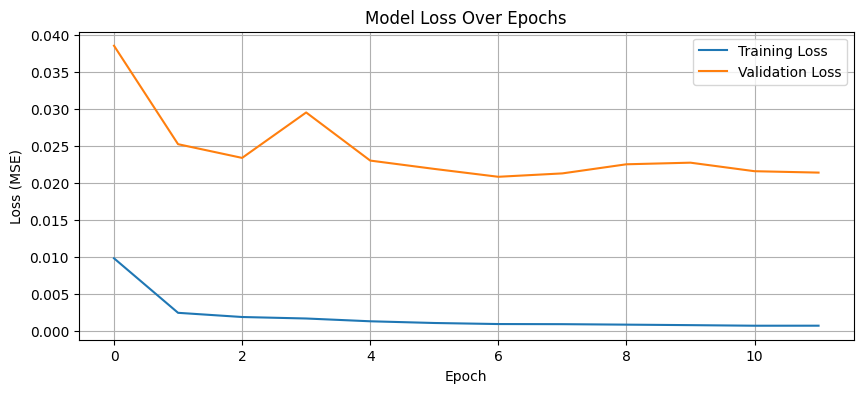

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
model_all26_features_total     | MAE: 27.979  MSE: 2115.008  RMSE: 45.989  R²: -0.779
model_all26_features_War       | MAE: 55.706  MSE: 5604.190  RMSE: 74.861  R²: -2.539
model_all26_features_PostWar   | MAE: 12.896  MSE: 221.271  RMSE: 14.875  R²: -3.581


In [ ]:
#@title model_multi_all26 with all 26 features

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'NetImports_Total', 'Inventories_Global', 'pipe_EU total',
       'TTFMc1', 'TTFMc2', 'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6', 'month',
       'sin_day', 'cos_day', 'PVB_Return', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_10selected_features = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_10selected_features.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_all26_features = model_all26_features.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_all26_features)

#@title Evaluate the model_all26_features result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_all26_features.predict(X_test)

# Inverse just the price component
y_pred_all26_features = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_all26_features = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_all26_features, y_pred_all26_features, label = 'model_all26_features_total', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_all26_features)]

y_pred_series = pd.Series(y_pred_all26_features, index=forecast_dates)
y_test_series = pd.Series(y_test_all26_features, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_all26_features_War', cutoff_date = cutoff_date, results_df=results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_all26_features_PostWar', cutoff_date = cutoff_date, results_df=results_df, features = features.columns.tolist())

In [ ]:
results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."


X_train shape: (1310, 365, 26)
X_test shape: (840, 365, 26)
y_train shape: (1310,)
y_test shape: (840,)
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - loss: 0.0185 - mae: 0.0990 - mape: 22099.4805 - rmse: 0.1354 - val_loss: 0.0229 - val_mae: 0.1359 - val_mape: 55.6386 - val_rmse: 0.1514 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - loss: 0.0091 - mae: 0.0661 - mape: 25135.8105 - rmse: 0.0954 - val_loss: 0.0270 - val_mae: 0.1481 - val_mape: 61.5981 - val_rmse: 0.1644 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - loss: 0.0072 - mae: 0.0569 - mape: 20493.7656 - rmse: 0.0848 - val_loss: 0.0248 - val_mae: 0.1414 - val_mape: 58.8103 - val_rmse: 0.1574 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.0073 - mae: 0.0580 - mape: 19555.8418 - rmse: 0.0855
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - loss: 0.0073 

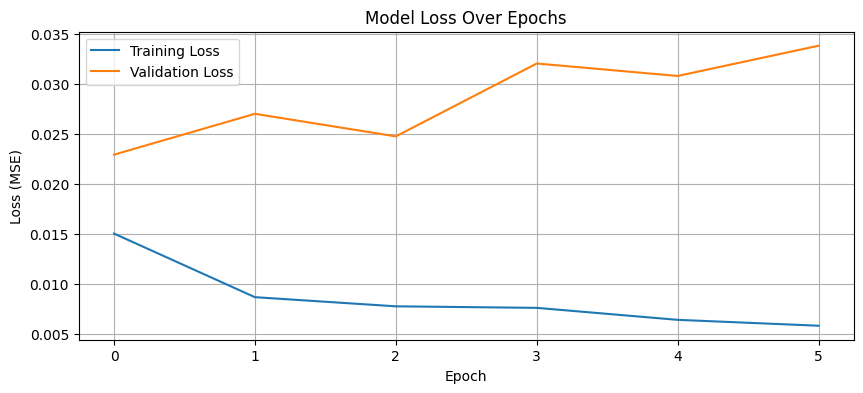

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step
model_all26_features_total     | MAE: 20.378  MSE: 457.059  RMSE: 21.379  R²: -8.713


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."


In [ ]:
#@title model_multi_all26 with all 26 features

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'Brent_Price', 'JKM_Price', 'Coal_Price', 'HH_Price',
       'TTF_Price', 'NetImports_Total', 'Inventories_Global', 'pipe_EU total',
       'TTFMc1', 'TTFMc2', 'TTFMc3', 'TTFMc4', 'TTFMc5', 'TTFMc6', 'month',
       'sin_day', 'cos_day', 'PVB_Return', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_10selected_features = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_10selected_features.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_10selected_features = model_10selected_features.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_10selected_features)

#@title Evaluate the model_10selected_features result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_10selected_features.predict(X_test)

# Inverse just the price component
y_pred_10selected_features = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_10selected_features = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_10selected_features, y_pred_10selected_features, label = 'model_10selected_features_total', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
results_df.to_csv('/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv', index=False)

In [ ]:
results_df = pd.read_csv('/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv')
results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."


X_train shape: (855, 365, 10)
X_test shape: (1295, 365, 10)
y_train shape: (855,)
y_test shape: (1295,)
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 419ms/step - loss: 0.0044 - mae: 0.0452 - mape: 6077.8301 - rmse: 0.0651 - val_loss: 0.0150 - val_mae: 0.0935 - val_mape: 22.8294 - val_rmse: 0.1224 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - loss: 0.0015 - mae: 0.0262 - mape: 7450.7363 - rmse: 0.0386 - val_loss: 0.0118 - val_mae: 0.0867 - val_mape: 23.0945 - val_rmse: 0.1086 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - loss: 0.0011 - mae: 0.0213 - mape: 5994.5576 - rmse: 0.0328 - val_loss: 0.0127 - val_mae: 0.0954 - val_mape: 26.2857 - val_rmse: 0.1125 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - loss: 9.3315e-04 - mae: 0.0210 - mape: 4455.7236 - rmse: 0.0305 - val_loss: 0.0185 - val_mae: 0.1153 - val_mape: 33.4036 - val_rmse: 0.1359 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━

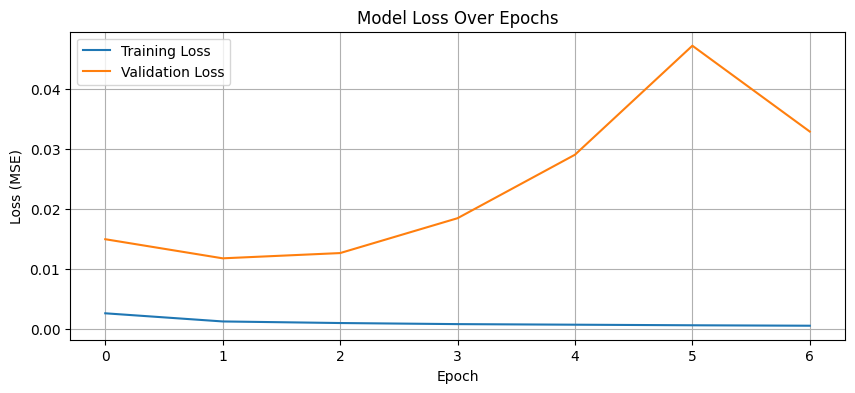

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step
model_10selected_features_total | MAE: 17.833  MSE: 737.283  RMSE: 27.153  R²:  0.380


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_10selected_features

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'JKM_Price','TTF_Price', 'TTFMc1', 'TTFMc2', 'MA_7', 'Volatility_30', 'rolling_std_30', 'z_score_30',
       'bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_10selected_features = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_10selected_features.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_10selected_features = model_10selected_features.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_10selected_features)

#@title Evaluate the model_10selected_features result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_10selected_features.predict(X_test)

# Inverse just the price component
y_pred_10selected_features = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_10selected_features = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_10selected_features, y_pred_10selected_features, label = 'model_10selected_features_total', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_10selected_features)]

y_pred_series = pd.Series(y_pred_10selected_features, index=forecast_dates)
y_test_series = pd.Series(y_test_10selected_features, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_10selected_features_War', cutoff_date = cutoff_date, results_df=results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_10selected_features_PostWar', cutoff_date = cutoff_date, results_df=results_df, features = features.columns.tolist())

model_10selected_features_War  | MAE: 32.238  MSE: 1761.247  RMSE: 41.967  R²: -0.112
model_10selected_features_PostWar | MAE:  8.759  MSE: 108.479  RMSE: 10.415  R²: -1.246


In [ ]:
results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


X_train shape: (1310, 365, 10)
X_test shape: (840, 365, 10)
y_train shape: (1310,)
y_test shape: (840,)
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 0.0314 - mae: 0.1108 - mape: 15530.8818 - rmse: 0.1713 - val_loss: 0.0199 - val_mae: 0.1054 - val_mape: 37.5296 - val_rmse: 0.1410 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 387ms/step - loss: 0.0103 - mae: 0.0604 - mape: 29219.9023 - rmse: 0.1013 - val_loss: 0.0248 - val_mae: 0.1378 - val_mape: 56.9549 - val_rmse: 0.1576 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 402ms/step - loss: 0.0093 - mae: 0.0611 - mape: 7601.4761 - rmse: 0.0964 - val_loss: 0.0242 - val_mae: 0.1315 - val_mape: 53.4221 - val_rmse: 0.1556 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 0.0065 - mae: 0.0503 - mape: 27714.5898 - rmse: 0.0801
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - loss: 0.0065 -

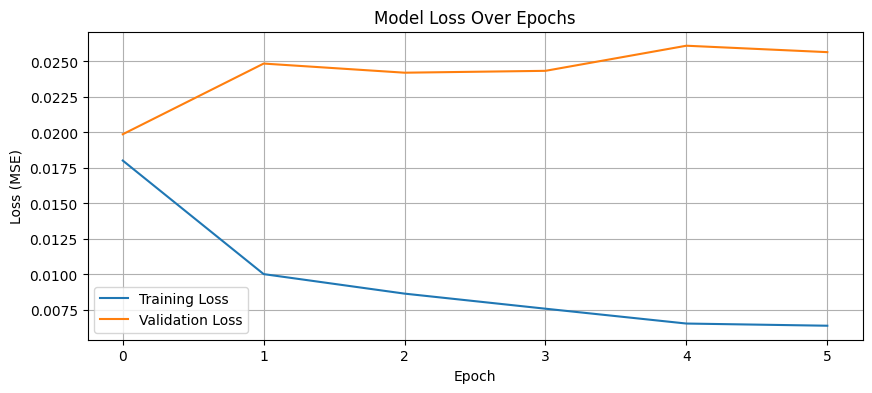

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
model_10selected_features_2023_total | MAE:  9.973  MSE: 127.597  RMSE: 11.296  R²: -1.712


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_10selected_features with cutoff_date 2023-03-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'JKM_Price','TTF_Price', 'TTFMc1', 'TTFMc2', 'MA_7', 'Volatility_30', 'rolling_std_30', 'z_score_30',
       'bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_10selected_features_2023 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_10selected_features_2023.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_10selected_features_2023 = model_10selected_features_2023.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_10selected_features_2023)

#@title Evaluate the model_10selected_features_2023 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_10selected_features_2023.predict(X_test)

# Inverse just the price component
y_pred_10selected_features_2023 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_10selected_features_2023 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_10selected_features_2023, y_pred_10selected_features_2023, label = 'model_10selected_features_2023_total', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

X_train shape: (855, 365, 5)
X_test shape: (1295, 365, 5)
y_train shape: (855,)
y_test shape: (1295,)
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - loss: 0.0028 - mae: 0.0389 - mape: 3890.4534 - rmse: 0.0520 - val_loss: 0.0115 - val_mae: 0.0897 - val_mape: 24.4766 - val_rmse: 0.1074 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - loss: 0.0011 - mae: 0.0229 - mape: 4672.6987 - rmse: 0.0334 - val_loss: 0.0148 - val_mae: 0.1062 - val_mape: 30.2237 - val_rmse: 0.1219 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - loss: 6.9974e-04 - mae: 0.0177 - mape: 70861.5703 - rmse: 0.0264 - val_loss: 0.0233 - val_mae: 0.1290 - val_mape: 37.9236 - val_rmse: 0.1526 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 8.4276e-04 - mae: 0.0184 - mape: 148.2470 - rmse: 0.0289
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - loss: 8.3706e

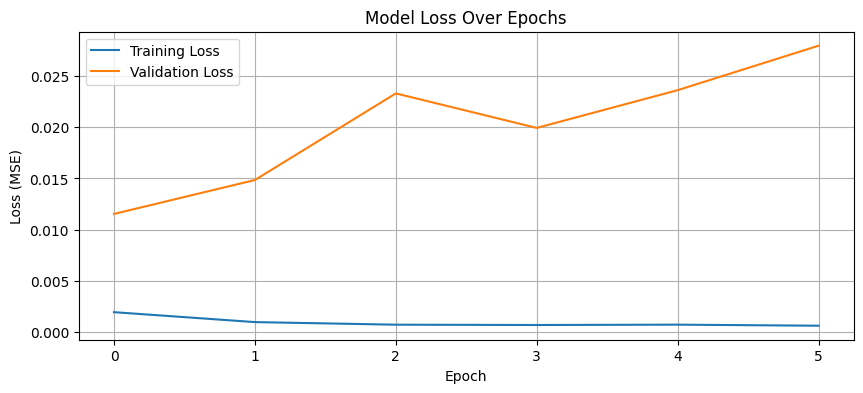

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
model_5selected_features_2021_total | MAE: 21.652  MSE: 997.515  RMSE: 31.583  R²:  0.161


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_5selected_features with cutoff_date 2021-12-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'JKM_Price','TTF_Price', 'rolling_std_30','bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_5selected_features_2021 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_5selected_features_2021.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_5selected_features_2021 = model_5selected_features_2021.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_5selected_features_2021)

#@title Evaluate the model_5selected_features_2021 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_5selected_features_2021.predict(X_test)

# Inverse just the price component
y_pred_5selected_features_2021 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_5selected_features_2021 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_5selected_features_2021, y_pred_5selected_features_2021, label = 'model_5selected_features_2021_total', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_5selected_features_2021)]

y_pred_series = pd.Series(y_pred_5selected_features_2021, index=forecast_dates)
y_test_series = pd.Series(y_test_5selected_features_2021, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_5selected_features_War', cutoff_date = cutoff_date, results_df=results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_5selected_features_PostWar', cutoff_date = cutoff_date, results_df=results_df, features = features.columns.tolist())

model_5selected_features_War   | MAE: 37.916  MSE: 2377.694  RMSE: 48.762  R²: -0.502
model_5selected_features_PostWar | MAE: 11.581  MSE: 170.628  RMSE: 13.062  R²: -2.532


In [ ]:
results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


X_train shape: (1310, 365, 3)
X_test shape: (840, 365, 3)
y_train shape: (1310,)
y_test shape: (840,)
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - loss: 0.0293 - mae: 0.1125 - mape: 6139.1323 - rmse: 0.1674 - val_loss: 0.0302 - val_mae: 0.1078 - val_mape: 32.6556 - val_rmse: 0.1738 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - loss: 0.0097 - mae: 0.0635 - mape: 13130.4717 - rmse: 0.0980 - val_loss: 0.0320 - val_mae: 0.1236 - val_mape: 41.5841 - val_rmse: 0.1789 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - loss: 0.0084 - mae: 0.0562 - mape: 114814.5781 - rmse: 0.0914 - val_loss: 0.0328 - val_mae: 0.1409 - val_mape: 53.3993 - val_rmse: 0.1811 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.0064 - mae: 0.0508 - mape: 2468.0989 - rmse: 0.0796
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - loss: 0.0064 - m

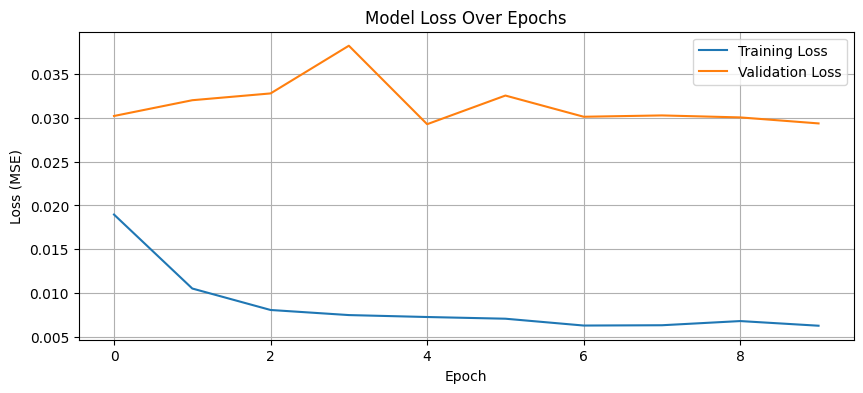

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
model_3selected_features_2023  | MAE: 14.823  MSE: 273.806  RMSE: 16.547  R²: -4.819


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_3selected_features with cutoff_date 2023-03-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price', 'bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test, y_pred, label = 'model_3selected_features_2023', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

X_train shape: (1310, 365, 2)
X_test shape: (840, 365, 2)
y_train shape: (1310,)
y_test shape: (840,)
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - loss: 0.0246 - mae: 0.1037 - mape: 17739.8828 - rmse: 0.1541 - val_loss: 0.0200 - val_mae: 0.0915 - val_mape: 27.6787 - val_rmse: 0.1415 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step - loss: 0.0138 - mae: 0.0707 - mape: 3728.0361 - rmse: 0.1170 - val_loss: 0.0220 - val_mae: 0.1269 - val_mape: 49.0828 - val_rmse: 0.1484 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - loss: 0.0102 - mae: 0.0582 - mape: 3721.4001 - rmse: 0.1002 - val_loss: 0.0224 - val_mae: 0.1364 - val_mape: 56.4031 - val_rmse: 0.1497 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 0.0092 - mae: 0.0596 - mape: 10264.2246 - rmse: 0.0959
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 398ms/step - loss: 0.0092 - ma

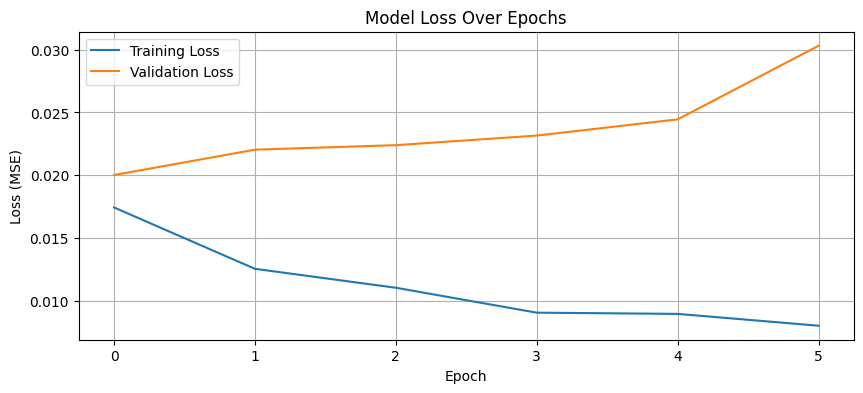

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
model_2selected_features_2023  | MAE:  4.799  MSE: 32.555  RMSE:  5.706  R²:  0.308


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_2selected_features with cutoff_date 2023-03-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test, y_pred, label = 'model_2selected_features_2023', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

X_train shape: (1676, 365, 2)
X_test shape: (474, 365, 2)
y_train shape: (1676,)
y_test shape: (474,)
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - loss: 0.0300 - mae: 0.1093 - mape: 145631.1875 - rmse: 0.1684 - val_loss: 5.2857e-04 - val_mae: 0.0202 - val_mape: 18.3491 - val_rmse: 0.0230 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - loss: 0.0130 - mae: 0.0694 - mape: 73304.4297 - rmse: 0.1139 - val_loss: 5.7310e-04 - val_mae: 0.0214 - val_mape: 19.2758 - val_rmse: 0.0239 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - loss: 0.0105 - mae: 0.0620 - mape: 34003.1562 - rmse: 0.1023 - val_loss: 0.0021 - val_mae: 0.0415 - val_mape: 37.9907 - val_rmse: 0.0455 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.0103 - mae: 0.0609 - mape: 25330.1289 - rmse: 0.1014
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - loss: 

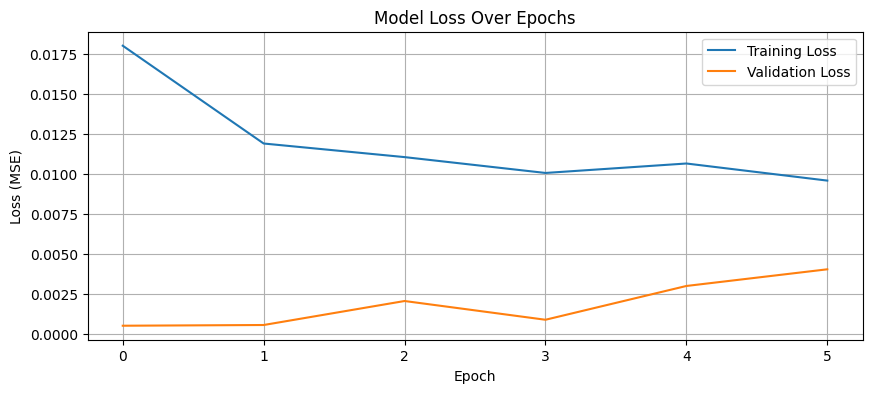

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step
model_2selected_features_2024  | MAE:  3.943  MSE: 23.381  RMSE:  4.835  R²:  0.443


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_2selected_features with cutoff_date 2024-03-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test, y_pred, label = 'model_2selected_features_2024', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

X_train shape: (1767, 365, 2)
X_test shape: (383, 365, 2)
y_train shape: (1767,)
y_test shape: (383,)
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 410ms/step - loss: 0.0221 - mae: 0.0979 - mape: 2262.0295 - rmse: 0.1468 - val_loss: 2.8726e-04 - val_mae: 0.0147 - val_mape: 14.2088 - val_rmse: 0.0169 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 385ms/step - loss: 0.0101 - mae: 0.0621 - mape: 69474.7891 - rmse: 0.1003 - val_loss: 0.0019 - val_mae: 0.0393 - val_mape: 39.1658 - val_rmse: 0.0442 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - loss: 0.0102 - mae: 0.0628 - mape: 10154.2061 - rmse: 0.1010 - val_loss: 5.4316e-04 - val_mae: 0.0170 - val_mape: 17.2861 - val_rmse: 0.0233 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.0113 - mae: 0.0617 - mape: 4266.8003 - rmse: 0.1057
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - loss: 0.0

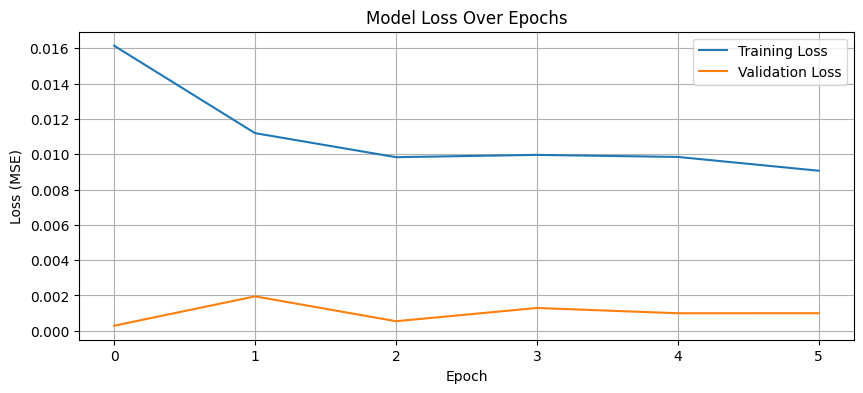

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step
model_2selected_features_2024_2 | MAE:  4.639  MSE: 30.127  RMSE:  5.489  R²:  0.205


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_2selected_features with cutoff_date 2024-06-30

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'TTF_Price']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2024-06-30'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test, y_pred, label = 'model_2selected_features_2024_2', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

X_train shape: (1676, 365, 5)
X_test shape: (474, 365, 5)
y_train shape: (1676,)
y_test shape: (474,)
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - loss: 0.0260 - mae: 0.1082 - mape: 8293.2881 - rmse: 0.1573 - val_loss: 0.0040 - val_mae: 0.0592 - val_mape: 53.8761 - val_rmse: 0.0629 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - loss: 0.0107 - mae: 0.0655 - mape: 2740.3486 - rmse: 0.1033 - val_loss: 0.0070 - val_mae: 0.0797 - val_mape: 71.1168 - val_rmse: 0.0835 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - loss: 0.0105 - mae: 0.0620 - mape: 4842.6089 - rmse: 0.1022 - val_loss: 0.0028 - val_mae: 0.0473 - val_mape: 42.3076 - val_rmse: 0.0527 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - loss: 0.0097 - mae: 0.0610 - mape: 10165.9229 - rmse: 0.0982 - val_loss: 0.0040 - val_mae: 0.0581 - val_mape: 51.6091 - val_rmse: 0.0632 - learning_rate: 0.0010
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━

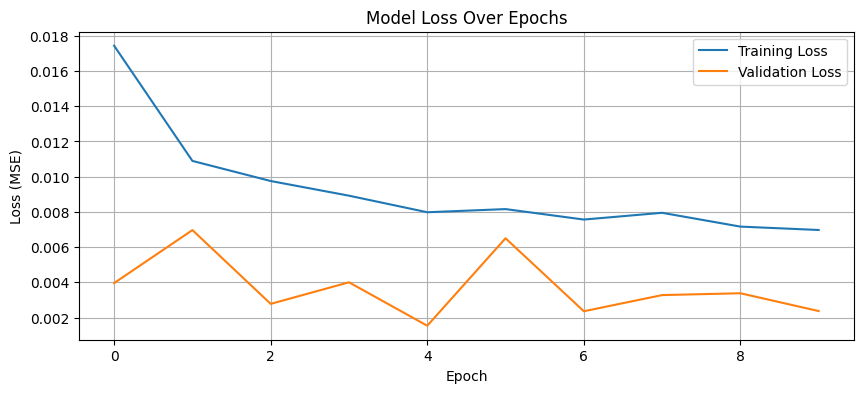

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step
model_5selected_features_2024  | MAE:  4.083  MSE: 24.681  RMSE:  4.968  R²:  0.412


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_single_feature,24.880787,2045.849692,45.231070,-0.720771,2021-12-31,PVB
1,model_single_feature_war,58.092209,5676.670588,75.343683,-2.988796,2021-12-31,PVB
2,model_single_feature_PostWar,6.891267,79.155040,8.896912,-0.682188,2021-12-31,PVB
3,model_single_feature,5.926961,57.801079,7.602702,-0.228378,2023-03-31,PVB
4,model_all26_features_total,27.978830,2115.007905,45.989215,-0.778940,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
5,model_all26_features_War,55.705756,5604.190415,74.861141,-2.539116,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
6,model_all26_features_PostWar,12.895922,221.270763,14.875173,-3.580818,2021-12-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
7,model_all26_features_total,20.378255,457.059442,21.378949,-8.713343,2023-03-31,"PVB, Brent_Price, JKM_Price, Coal_Price, HH_Pr..."
8,model_10selected_features_total,17.832639,737.282812,27.152952,0.379869,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."
9,model_10selected_features_War,32.238442,1761.246584,41.967208,-0.112249,2021-12-31,"PVB, JKM_Price, TTF_Price, TTFMc1, TTFMc2, MA_..."


In [ ]:
#@title model_5selected_features with cutoff_date 2024-03-31

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['PVB', 'JKM_Price','TTF_Price', 'rolling_std_30','bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_5selected_features_2021 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_5selected_features_2021.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_5selected_features_2021 = model_5selected_features_2021.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_5selected_features_2021)

#@title Evaluate the model_5selected_features_2021 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_5selected_features_2021.predict(X_test)

# Inverse just the price component
y_pred_5selected_features_2021 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_5selected_features_2021 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_5selected_features_2021, y_pred_5selected_features_2021, label = 'model_5selected_features_2024', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
results_df.to_csv('/content/drive/My Drive/BKW/Models/PVB/results_df_pvb_models.csv', index=False)

In [ ]:
#@title Gridsearch based on the best model so far model_2selected_features_2024
# Feature selection
feature_cols = ['PVB', 'TTF_Price']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[feature_cols])
total_features = scaled.shape[1]

# Hyperparameter grid
window_sizes = [90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]

# Fixed cutoff date
cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)

experiment_results = []

for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons for {window_size}', leave=False):
        buffer = window_size + horizon_days - 1
        scaled_train = scaled[:split_idx + 1]
        scaled_test = scaled[split_idx + 1 - buffer:]

        try:
            X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
            X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)
        except:
            print(f"❌ Skipping combo: window={window_size}, horizon={horizon_days} — sequence creation failed")
            continue

        if len(X_train) < 10:
            print(f"⚠️ Too few training samples for window={window_size}, horizon={horizon_days}")
            continue

        # Validation split
        val_size = int(len(X_train) * 0.1)
        X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

        for lstm1, lstm2 in lstm_units_list:
            for drop1, drop2 in dropout_configs:
                K.clear_session()

                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[
                        MeanAbsoluteError(name='mae'),
                        RootMeanSquaredError(name='rmse'),
                        MeanAbsolutePercentageError(name='mape')
                    ]
                )

                # Callbacks
                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

                model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                # Predict & inverse
                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=total_features)
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=total_features)

                # Metrics
                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'cutoff_date': cutoff_date,
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2
                })
                if len(experiment_results) % 5 == 0:
                  pd.DataFrame(experiment_results).to_csv("/content/drive/My Drive/BKW/Models/PVB/model_2selected_features_gridsearch_checkpoint.csv", index=False)

# Save results
results_df = pd.DataFrame(experiment_results)
results_df.to_csv(
    "/content/drive/My Drive/BKW/Models/PVB/model_2selected_features_gridsearch.csv",
    index=False
)

Window Sizes: 100%|██████████| 3/3 [10:35<00:00, 211.91s/it]


In [ ]:
results_df.sort_values(by='R2', ascending=False).head(10)

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
41,2024-03-31,365,30,64,32,0.5,0.3,3.709188,4.597553,9.457112,0.496622
38,2024-03-31,365,30,32,16,0.5,0.3,3.747699,4.679740,9.674431,0.478464
3,2024-03-31,90,30,64,32,0.2,0.1,3.879255,4.761518,9.995692,0.460078
36,2024-03-31,365,30,32,16,0.2,0.1,3.792287,4.795530,9.840162,0.452336
22,2024-03-31,180,30,64,32,0.4,0.2,3.940472,4.857822,10.334473,0.438016
0,2024-03-31,90,30,32,16,0.2,0.1,3.961257,4.872532,10.013022,0.434608
5,2024-03-31,90,30,64,32,0.5,0.3,3.677911,4.880725,9.781659,0.432705
39,2024-03-31,365,30,64,32,0.2,0.1,4.419948,5.206833,11.208544,0.354364
2,2024-03-31,90,30,32,16,0.5,0.3,4.406087,5.211764,11.202897,0.353141
1,2024-03-31,90,30,32,16,0.4,0.2,4.531628,5.275789,11.687860,0.337150


In [ ]:
best_rows = results_df.loc[
    results_df.groupby(['horizon_days'])['R2'].idxmax()
].reset_index(drop=True)
best_rows

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
0,2024-03-31,365,30,64,32,0.5,0.3,3.709188,4.597553,9.457112,0.496622
1,2024-03-31,90,60,32,16,0.2,0.1,4.725934,6.305416,12.427401,0.053179
2,2024-03-31,365,90,32,16,0.4,0.2,5.649184,7.170556,15.411488,-0.224464


In [24]:
#@title reset the gridsearch and save the best models
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm

# Set global seed for reproducibility
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_global_seed(42)

# Optional: ensure deterministic ops
# tf.config.experimental.enable_op_determinism()

# Feature selection
feature_cols = ['PVB', 'TTF_Price']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[feature_cols])
total_features = scaled.shape[1]

# Hyperparameter grid
window_sizes = [90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]

cutoff_date = '2024-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)

experiment_results = []
best_mae_by_horizon = {}

for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons for {window_size}', leave=False):
        buffer = window_size + horizon_days - 1
        scaled_train = scaled[:split_idx + 1]
        scaled_test = scaled[split_idx + 1 - buffer:]

        try:
            X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
            X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)
        except:
            print(f"❌ Skipping combo: window={window_size}, horizon={horizon_days} — sequence creation failed")
            continue

        if len(X_train) < 10:
            print(f"⚠️ Too few training samples for window={window_size}, horizon={horizon_days}")
            continue

        val_size = int(len(X_train) * 0.1)
        X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

        for lstm1, lstm2 in lstm_units_list:
            for drop1, drop2 in dropout_configs:
                set_global_seed(42)  # reset seed before every model
                tf.keras.backend.clear_session()

                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse'), MeanAbsolutePercentageError(name='mape')]
                )

                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

                model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=total_features)
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=total_features)

                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'cutoff_date': cutoff_date,
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2,
                    'seed': 42
                })

                key = f"horizon_{horizon_days}"
                if key not in best_mae_by_horizon or mae < best_mae_by_horizon[key]:
                    model.save(f"/content/drive/My Drive/BKW/Models/PVB/best_model_h{horizon_days}.keras")
                    best_mae_by_horizon[key] = mae

                if len(experiment_results) % 5 == 0:
                    pd.DataFrame(experiment_results).to_csv("/content/drive/My Drive/BKW/Models/PVB/model_2selected_features_gridsearch_checkpoint.csv", index=False)

# Save final results
results_df = pd.DataFrame(experiment_results)
results_df.to_csv("/content/drive/My Drive/BKW/Models/PVB/model_2selected_features_gridsearch.csv", index=False)


Window Sizes: 100%|██████████| 3/3 [10:14<00:00, 204.95s/it]


In [29]:
results_df = pd.read_csv("/content/drive/My Drive/BKW/Models/PVB/model_2selected_features_gridsearch.csv")
best_mae = results_df.loc[
    results_df.groupby(['horizon_days'])['mae'].idxmin()
].reset_index(drop=True)
best_mae

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2,seed
0,2024-03-31,180,30,32,16,0.5,0.3,3.664333,4.777045,9.741680,0.456550,42
1,2024-03-31,180,60,32,16,0.5,0.3,4.429207,6.172392,11.689524,0.092707,42
2,2024-03-31,180,90,32,16,0.5,0.3,5.950086,7.347660,15.706119,-0.285697,42


In [28]:
best_r2 = results_df.loc[
    results_df.groupby(['horizon_days'])['R2'].idxmax()
].reset_index(drop=True)
best_r2

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2,seed
0,2024-03-31,90,30,32,16,0.5,0.3,3.706772,4.670884,9.559604,0.480437,42
1,2024-03-31,180,60,32,16,0.5,0.3,4.429207,6.172392,11.689524,0.092707,42
2,2024-03-31,180,90,32,16,0.5,0.3,5.950086,7.347660,15.706119,-0.285697,42
